# Numerical simulation of multiple SLE

This code uses the work of https://github.com/hfcredidio/loew and https://github.com/andrea-dm/schramm-loewner-evolution. The numerical simulation is based on Kennedy, T., "Numerical Computations for the Schramm-Loewner Evolution", J Stat Phys (2009) 137: 839. doi:10.1007/s10955-009-9866-2.



First, load some packages and functions:

In [0]:
!pip install sdeint
import numpy                as np
import numexpr              as ne
import sdeint    # for solving stochastic differential equations numerically           
import matplotlib.pylab as plt

def vslit_zip(z, dt, u):
    '''
    Vertical slit discretication of chordal Loewner chains. This function is
    the inverse of the solution of Loewner's Equation with driving function
    U(t) = u, for 0 <= t <= dt
    It maps the origin to the point w = u + 2j * dt**0.5
    Parameters
    ----------
    z : complex or ndarray of complexes
        Input array.
    dt: float
    u: float
        Vertical slit parameters.
    Returns
    -------
    w : complex or ndarray of complxes
        Same shape as input array.
    '''
    return ne.evaluate("1j * sqrt(4 * dt - (z-u) ** 2) + u")


def multiple_slits(t, lambdas, u) :
    '''
    ----------
    Parameters
    ----------
    t:              1d ndarray of floats
                            Time instants where the driving is sampled.
    lambdas: array containing the nslits many coefficients >=0
    *driven_fncs:   n 1d ndarrays of floats
                            Sampled values of the driving functions.

    ----------
    Returns
    -------
    z: list of n 1d ndarray of complex
        Points of the trace at each time instant.

    ----------
    '''
    nsteps = len(t)

    nslits = u.shape[0]
        
    #initializing the trace array...
    z = np.empty([nslits,nsteps], dtype=np.complex)
  #  for slit in range(0,nslits) :
  #      z[slit][:nsteps] += (u[slit][:nsteps]+0.000001j)
        
    for m in range(0, nslits, 1):
        for j in range(0, nsteps, 1):
            z[m][j] =  u[m][j]+0.000001j

    #getting the trace...
    for step in range(nsteps-1, 0, -1):
        dt = (t[step] - t[step-1])            
        for slit1 in range(0, nslits, 1): 
            for slit2 in range(0, nslits, 1): 
                z[slit2][step:] = vslit_zip(z[slit2][step:], dt*lambdas[slit1], u[slit1][step])

    #done!
    return z


def single_slit(t, u) :

    z = multiple_slits(t,[1], u)
    return z[0][:]
    
def multiple_sle_driving_functions(kappa, Nslits, x0, tspan, lambdas):
    '''
    ----------
    Parameters
    ----------
    kappa:  the 'kappa' of SLE(kappa)
    Nslits: number of multiple sle slits
    x0: array of the initial (real) points of the slits
    tspan: time points
    lambdas: array containing the nslits many coefficients >=0
    ----------
    Returns
    -------
    result: array of dimension len(tspan)*Nslits of real
            numbers, representing the Nslits driving functions

    ----------
    '''

    diag = np.sqrt([kappa * x for x in lambdas])

   # diag = diag + np.sqrt(kappa * lambda)
    B = np.diag(diag) # diagonal, so independent Brownian motions

#x0 = np.array([1.0, -1.0])
    #x0 = np.linspace(-4/Nslits, 4/Nslits, Nslits)

    def f(x, t):
        res = np.zeros(Nslits, dtype=np.float_)
        for k in range(0, Nslits, 1):
            for m in range(0, Nslits, 1):
                if k != m:
                    res[k] = res[k] + 2*(lambdas[k]+lambdas[m])/(x[k]-x[m])
   # return np.array([2/(x[0]-x[1]), 2/(x[1]-x[0])])
        return np.array(res)

    def G(x, t):
        return B

    result = sdeint.itoint(f, G, x0, tspan)
    result = np.transpose(result)
    
    return result
    
def mysqrt(x):
    if np.any(np.angle(x) > 0): 
        return np.exp(1j * np.angle(x) / 2) * np.sqrt(np.sqrt(np.real(x)**2 + np.imag(x)**2))
    else:
        return np.exp(1j * (np.angle(x)+2*np.pi) / 2) * np.sqrt(np.sqrt(np.real(x)**2 + np.imag(x)**2))


def burgers(t, N):
    B = np.diag([0]) # diagonal, so independent Brownian motions
    T = t[-1]
    result = []

    def f(x, t):
        res = np.sqrt(x**2-16*(T-t))
        if (res.imag > 0):
            return -4/(x+ res)
        return -4/(x- res)

    for j in range(0, N, 1):
        bremen = sdeint.itoint(f, lambda x,t : B, -5+10*j/N + 1j/1000, t)
        munich = bremen[-1]
        result.append(np.complex(munich[0]))  

    output = np.empty(len(result), np.complex128)
    for i in range(len(result)) :
        output[i] = np.complex(result[i])

    return output

# Example 1: One slit (a straight line)

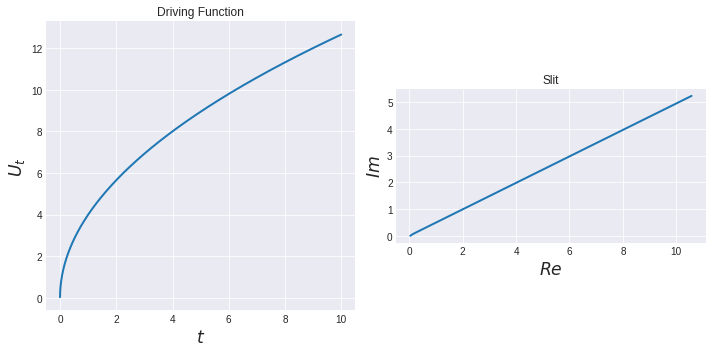

In [0]:
# Parameters
#======================
end_time = 10
t = np.linspace(0.0001, end_time, 10000)
U = 4*np.sqrt(t) # driving function
#======================


u=np.zeros([1, len(t)], dtype=np.complex128)
u[0,:]=U

# compute the trace in the upper half-plane
result = multiple_slits(t, [1], u)  # returns a complex ndarray
result = result[0,]

plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].set_title('Driving Function')
axs[0].plot(t, U, lw=2)

axs[1].set_title('Slit')
axs[1].plot(result.real, result.imag, lw=2)

axs[0].set_xlabel('$t$', fontsize='xx-large')
axs[0].set_ylabel('$U_t$', fontsize='xx-large')
axs[1].set_aspect('equal')
axs[1].set_xlabel('$Re$', fontsize='xx-large')
axs[1].set_ylabel('$Im$', fontsize='xx-large')
fig.tight_layout()

#Example 2: oscillating driving function

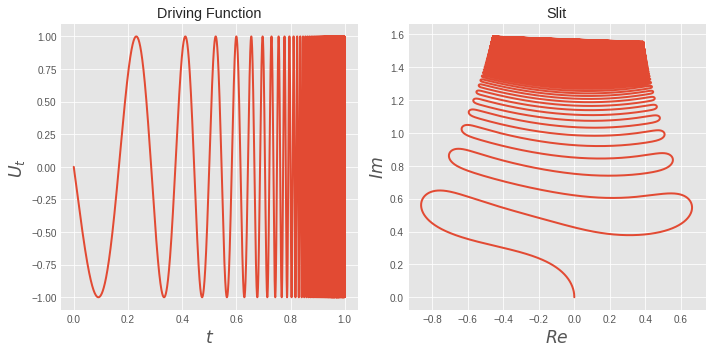

In [0]:
# Parameters
#======================
end_time = 1
t = np.linspace(0.0, 1.0, 100000)
U = u1 = np.sin( np.pi* 5/(end_time+0.00001-t) )
#======================


u = np.zeros([1, len(t)], dtype=np.complex128)
u[0,:]=U

# compute the trace in the upper half-plane
result = multiple_slits(t, [1], u)  # returns a complex ndarray
result = result[0,]
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].set_title('Driving Function')
axs[0].plot(t, U, lw=2)

axs[1].set_title('Slit')
axs[1].plot(result.real, result.imag, lw=2)

axs[0].set_xlabel('$t$', fontsize='xx-large')
axs[0].set_ylabel('$U_t$', fontsize='xx-large')
#axs[1].set_aspect('equal')
axs[1].set_xlabel('$Re$', fontsize='xx-large')
axs[1].set_ylabel('$Im$', fontsize='xx-large')
fig.tight_layout()



# Example 3: two slits

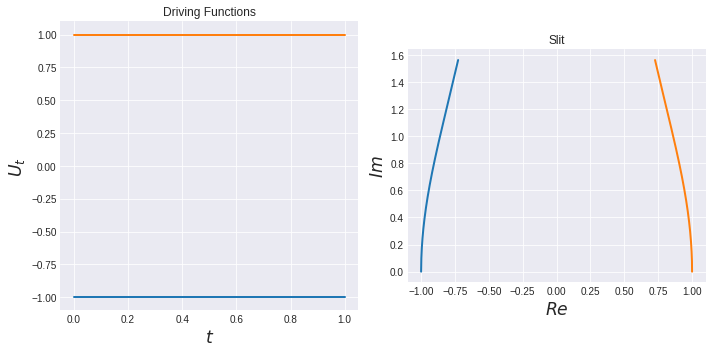

In [0]:
# Parameters
#======================
number_of_slits = 2
end_time = 1
t = np.linspace(0.0, 1.0, 1000)
u1 = np.zeros(len(t)) - 1  # driving function constant -1
u2 = np.zeros(len(t)) + 1  # driving function constant +1
weights = [1/2, 1/2]
#======================


u = np.zeros([number_of_slits, len(t)], dtype=np.complex128)
u[0,:] = u1
u[1,:] = u2

# compute the trace in the upper half-plane
result = multiple_slits(t, weights, u)  # returns a complex ndarray
z1 = result[0,]
z2 = result[1,]
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].set_title('Driving Functions')
axs[0].plot(t, u1, lw=2)
axs[0].plot(t, u2, lw=2)
axs[1].set_title('Slit')
axs[1].plot(z1.real, z1.imag, lw=2)
axs[1].plot(z2.real, z2.imag, lw=2)
axs[0].set_xlabel('$t$', fontsize='xx-large')
axs[0].set_ylabel('$U_t$', fontsize='xx-large')
axs[1].set_aspect('equal')
axs[1].set_xlabel('$Re$', fontsize='xx-large')
axs[1].set_ylabel('$Im$', fontsize='xx-large')
fig.tight_layout()

# Example 4: Multiple SLE

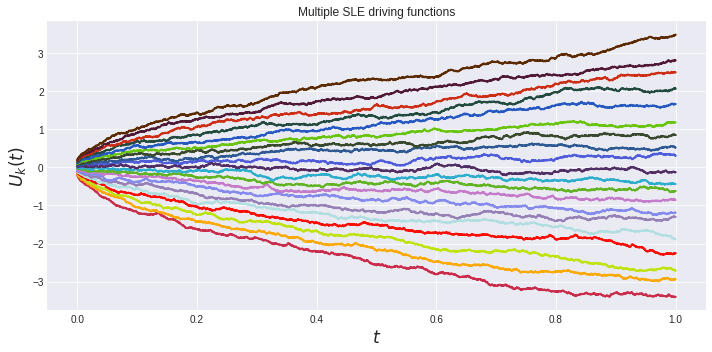

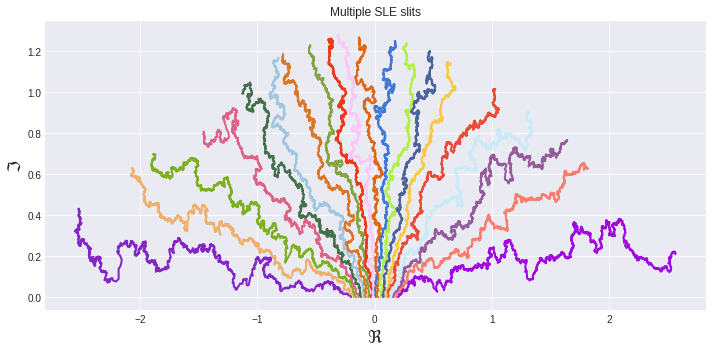

In [0]:
# Parameters
#======================
Nslits = 20
end_time = 1
x0 = np.linspace(-4/Nslits, 4/Nslits, Nslits)
tspan = np.linspace(0.0, end_time, 5000)
lambdas = np.zeros(Nslits, dtype=np.float_) + 1/Nslits
kappa = 2 # the kappa from SLE(kappa)
#======================

#==============================================================================
# sum=0
# for k in range(0, Nslits, 1): 
#     lambdas[k] = 1/(k+1)
#     sum = sum + lambdas[k]
# for k in range(0, Nslits, 1): 
#     lambdas[k] = lambdas[k] / sum
#==============================================================================

u = multiple_sle_driving_functions(kappa, Nslits, x0, tspan, lambdas)

z = multiple_slits(tspan, lambdas, u)  # returns a complex ndarray

fig, axs = plt.subplots(figsize=(10, 5))
axs.set_title('Multiple SLE driving functions')

for k in range(0, Nslits, 1): 
    axs.plot(tspan, u[k,:], lw=2,  color=np.random.rand(3,1)[:,0])  #different red colors: color=[k/Nslits,0,0]
#axs.set_aspect('equal')
axs.set_xlabel('$t$', fontsize='xx-large')
axs.set_ylabel('$U_k(t)$', fontsize='xx-large')
fig.tight_layout()

fig, axs = plt.subplots(figsize=(10, 5))
axs.set_title('Multiple SLE slits')
for k in range(0, Nslits, 1): 
    axs.plot(z[k,:].real, z[k,:].imag, lw=2,  color=np.random.rand(3,1)[:,0])
#axs.set_aspect('equal')
axs.set_xlabel('$\Re$', fontsize='xx-large')
axs.set_ylabel('$\Im$', fontsize='xx-large')
#plt.ylim(0, 1)
#plt.xlim(-10, 10)
fig.tight_layout()

plt.show()


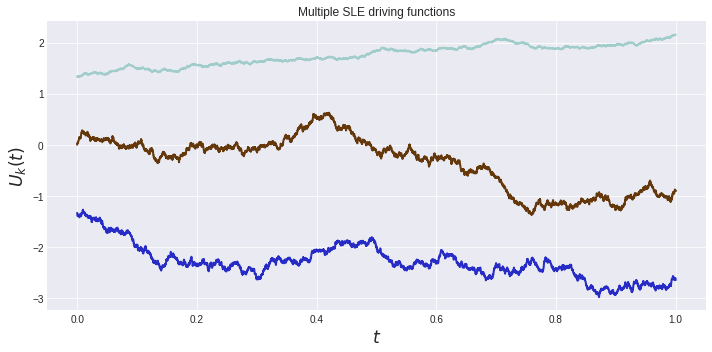

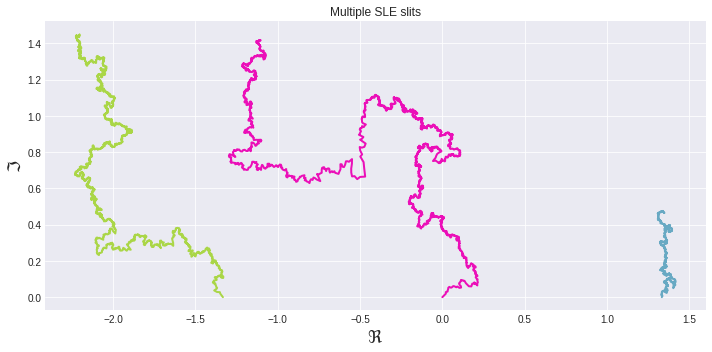

In [0]:
# Parameters
#======================
Nslits = 3
end_time = 1
x0 = np.linspace(-4/Nslits, 4/Nslits, Nslits)
tspan = np.linspace(0.0, end_time, 5000)
lambdas = [0.48, 0.48, 0.04]
kappa = 2 # the kappa from SLE(kappa)
#======================

u = multiple_sle_driving_functions(kappa, Nslits, x0, tspan, lambdas)

z = multiple_slits(tspan, lambdas, u)  # returns a complex ndarray

fig, axs = plt.subplots(figsize=(10, 5))
axs.set_title('Multiple SLE driving functions')

for k in range(0, Nslits, 1): 
    axs.plot(tspan, u[k,:], lw=2,  color=np.random.rand(3,1)[:,0])
#axs.set_aspect('equal')
axs.set_xlabel('$t$', fontsize='xx-large')
axs.set_ylabel('$U_k(t)$', fontsize='xx-large')
fig.tight_layout()

fig, axs = plt.subplots(figsize=(10, 5))
axs.set_title('Multiple SLE slits')
for k in range(0, Nslits, 1): 
    axs.plot(z[k,:].real, z[k,:].imag, lw=2,  color=np.random.rand(3,1)[:,0])
#axs.set_aspect('equal')
axs.set_xlabel('$\Re$', fontsize='xx-large')
axs.set_ylabel('$\Im$', fontsize='xx-large')
#plt.ylim(0, 1)
#plt.xlim(-10, 10)
fig.tight_layout()

#plt.show()


# Plot the hull from the Burgers equation with initial measure = Dirac measure at 0.

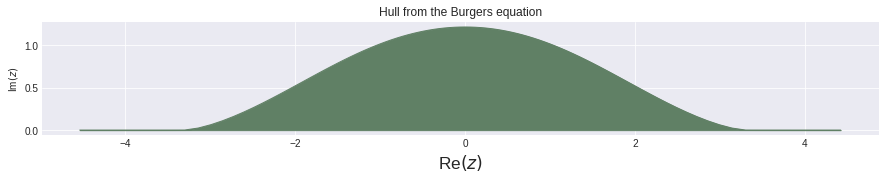

In [0]:
end_time = 1

plt.style.use('seaborn-darkgrid')

result = burgers(np.linspace(0, end_time, 300), 100)


col=np.random.rand(3,1) # we use a random color for plotting
plt.figure(figsize=(15,15))
plt.plot(result.real, result.imag, lw=1, color=col[:,0])
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title('Hull from the Burgers equation')
ax.set_xlabel('Re$(z)$', fontsize='xx-large')
ax.set_ylabel('Im$(z)$')
ax.fill_between(result.real, result.imag, color=col[:,0])
ax.set_alpha(0.0)

plt.show()

Plot the Burgers hull and multiple SLE slits with equal weights, which approximate the hull:

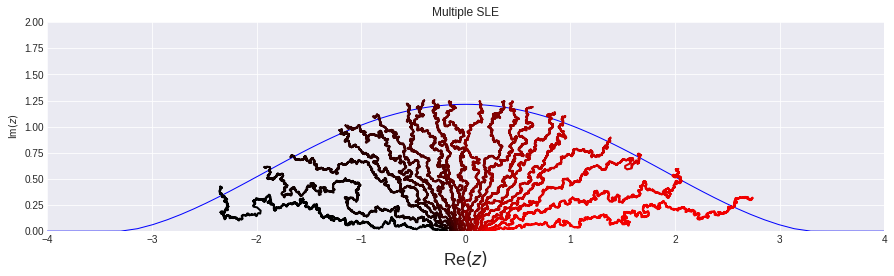

In [2]:
# Parameters
#======================
end_time = 1
Nslits = 20
x0 = np.linspace(-4/Nslits, 4/Nslits, Nslits)
tspan = np.linspace(0.0, end_time, 10000)
lambdas = np.zeros(Nslits, dtype=np.float_) + 1/Nslits
kappa = 2 # the kappa from SLE(kappa)
#======================


u = multiple_sle_driving_functions(kappa, Nslits, x0, tspan, lambdas)

z = multiple_slits(tspan, lambdas, u)  # returns a complex ndarray

result2 = burgers(np.linspace(0, end_time, 300), 100)

col=np.random.rand(3,1) # we use a random color for plotting

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,15))

plt.plot(result2.real, result2.imag, lw=1, color=[0,0,1])
for k in range(0, Nslits, 1): 
    plt.plot(z[k,:].real, z[k,:].imag, lw=2,  color=[k/Nslits,0,0])
plt.ylim(0, 2)
plt.xlim(-4, 4)
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title('Multiple SLE')
ax.set_xlabel('Re$(z)$', fontsize='xx-large')
ax.set_ylabel('Im$(z)$')
#ax.fill_between(result2.real, result2.imag, color=col[:,0])
ax.set_alpha(0.0)

plt.show()